In [1]:
import numpy as np
from matplotlib import pyplot as plt
# from jupyterthemes import jtplot
# jtplot.style()

In [2]:
A = np.array([
             [0., 0., 0.,  1.],
             [0., 0., -1., 0.],
             [0., -1., 0., 0.],
             [1., 0.,  0., 0.]
            ])

'''
    RHS of Maxwell's Equations
'''
def maxwell_rhs(u, h, N):
    
    rhs      = np.zeros_like(u)
    M        = np.zeros((N+1,N+1))
    num_cols = len(u[0])
    
    for i in range (N):
        M[i,i+1] = 1.
        M[i+1,i] = -1.
        
    M[0,-1] = -1.
    M[-1,0] = 1.
    M       = .5/h * M
    
    u_vec = np.dot(A,u.T)
    u_vec = u_vec.T
   
    for col in range(num_cols):
        rhs[:,col] = np.dot(M,u_vec[:,col])
    
    return rhs

'''
    RK4 Routine
'''
def rk4_step(u, rhs_func, dt, h, **kwargs):
    k1 = rhs_func(u, h, **kwargs)
    k2 = rhs_func(u + .5 * dt * k1, h, **kwargs)
    k3 = rhs_func(u + .5 * dt * k2, h, **kwargs)
    k4 = rhs_func(u + dt * k3, h, **kwargs)

    return u + dt/6. * (k1 + 2.*k2 + 2.*k3 + k4)

In [3]:
'''
    Evolve the system using RK4
'''

T_FINAL = 10.
COURANT = .5
z0      = 0.
zf      = 1. 

def solve_system(N_MAX):
    
    h       = (zf - z0) / N_MAX
    z_grid  = np.linspace(z0, zf-h, N_MAX + 1)
    dt      = h * COURANT

    U  = np.zeros((N_MAX+1,4))
    t  = 0.

    while t <= T_FINAL:

        w = 2. * np.pi * (t - z_grid)
        U[:,0] = np.sin(w)     # B_x
        U[:,1] = np.cos(w)     # B_y
        U[:,2] = np.cos(w)     # E_x
        U[:,3] = -np.sin(w)    # E_y

        U = rk4_step(U, maxwell_rhs, dt, h, N = N_MAX)
        t += dt
        
    return z_grid, U

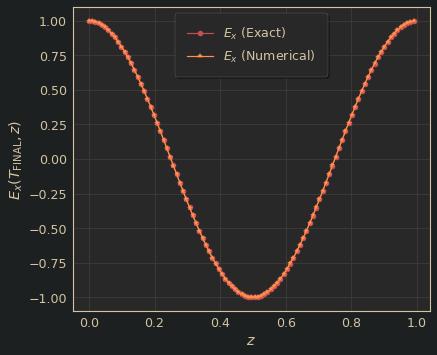

In [4]:
'''
    Exact Solutions (Eqs (10))
'''

def magnetic_field_exact(t,z):
    w  = 2. * np.pi * (t-z)
    Bx = np.sin(w)
    By = np.cos(w)
    B  = np.array((Bx, By))
    return B

def electric_field_exact(t,z):
    w  = 2. * np.pi * (t-z)
    Ex = np.cos(w)
    Ey = - np.sin(w)
    E  = np.array((Ex, Ey))
    return E

'''
    Numerical Solutions (N_MAX = 100)
'''
z_grid = solve_system(100)[0]
U      = solve_system(100)[1]

B_x = U[:,0] 
B_y = U[:,1] 
E_x = U[:,2] 
E_y = U[:,3] 

magnetic_field = np.array((B_x, B_y))
electric_field = np.array((E_x, E_y))


'''
    Compare Solutions (E_x)
'''

plt.plot(z_grid, electric_field_exact(T_FINAL,z_grid)[0], 'ro-', label = r'$E_x$ (Exact)')   # E_x
plt.plot(z_grid, electric_field[0], 'y-*', label = r'$E_x$ (Numerical)')      # E_x  (numerical)

plt.xlabel(r'$z$')
plt.ylabel(r'$E_x(T_{\rm{FINAL}}, z)$')
plt.legend(fancybox=True, framealpha=1, borderpad=1, shadow=True)


plt.show()
# plt.savefig('Figures/Ex_vs_ExExact.pdf')
plt.close()

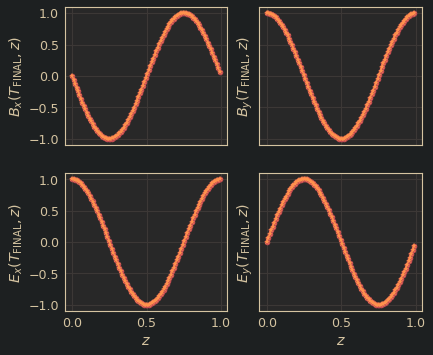

In [5]:
'''
    Compare Solutions (All Fields)
'''

fig, ((Bx, By), (Ex, Ey)) = plt.subplots(2,2, sharex=True, sharey=True)  

Bx.plot(z_grid, magnetic_field_exact(T_FINAL,z_grid)[0], 'ro-')   # B_x
Bx.plot(z_grid, magnetic_field[0], 'y*-')      # B_x  (numerical)

By.plot(z_grid, magnetic_field_exact(T_FINAL,z_grid)[1], 'ro-')   # B_y
By.plot(z_grid, magnetic_field[1], 'y*-')      # B_y  (numerical)

Ex.plot(z_grid, electric_field_exact(T_FINAL,z_grid)[0], 'ro-')   # E_x
Ex.plot(z_grid, electric_field[0], 'y*-')      # E_x  (numerical)

Ey.plot(z_grid, electric_field_exact(T_FINAL,z_grid)[1], 'ro-')   # E_y
Ey.plot(z_grid, electric_field[1], 'y*-')      # E_y  (numerical)

Bx.set(ylabel=r'$B_x(T_{\rm{FINAL}}, z)$')
By.set(ylabel=r'$B_y(T_{\rm{FINAL}}, z)$')
Ex.set(ylabel=r'$E_x(T_{\rm{FINAL}}, z)$')
Ey.set(ylabel=r'$E_y(T_{\rm{FINAL}}, z)$')

Ex.set(xlabel=r'$z$')
Ey.set(xlabel=r'$z$')

plt.show()
# plt.savefig('Figures/all_fields.pdf')
plt.close()

In [6]:
'''
    N-test
'''

N_list  = [200, 250, 300, 350, 400]
Bx_test = []
By_test = []
Ex_test = []
Ey_test = []

for N in N_list:
    
    sol    = solve_system(N)[1]
    z_grid = solve_system(N)[0]
    
    B_x = sol[:,0] 
    B_y = sol[:,1] 
    E_x = sol[:,2] 
    E_y = sol[:,3] 
    
    Bx_exact = magnetic_field_exact(T_FINAL,z_grid)[0]
    By_exact = magnetic_field_exact(T_FINAL,z_grid)[1]
    Ex_exact = electric_field_exact(T_FINAL,z_grid)[0]
    Ey_exact = electric_field_exact(T_FINAL,z_grid)[1]
    
    Bx_error = np.linalg.norm(Bx_exact - B_x, ord = np.inf)
    By_error = np.linalg.norm(By_exact - B_y, ord = np.inf)
    Ex_error = np.linalg.norm(Ex_exact - E_x, ord = np.inf)
    Ey_error = np.linalg.norm(Ey_exact - E_y, ord = np.inf)
    
    Bx_test.append(Bx_error)
    By_test.append(By_error)
    Ex_test.append(Ex_error)
    Ey_test.append(Ey_error)

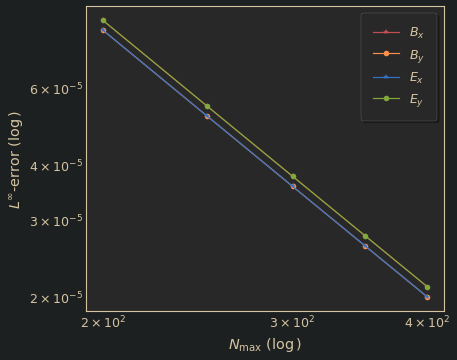

In [10]:
'''
    Plot results from N-test
'''
plt.loglog(N_list, Bx_test, 'r*-', label = r'$B_x$')   
plt.loglog(N_list, By_test, 'yo-', label = r'$B_y$') 
plt.loglog(N_list, Ex_test, 'b*-', label = r'$E_x$') 
plt.loglog(N_list, Ey_test, 'go-', label = r'$E_y$') 

plt.xlabel(r'$N_{\rm max}$ ($\log$)')
plt.ylabel(r'$L^{\infty}$-error ($\log$)')
plt.legend(fancybox=True, framealpha=1, borderpad=1, shadow=True)

plt.show()
# plt.savefig('Figures/N_test.pdf')
plt.close()

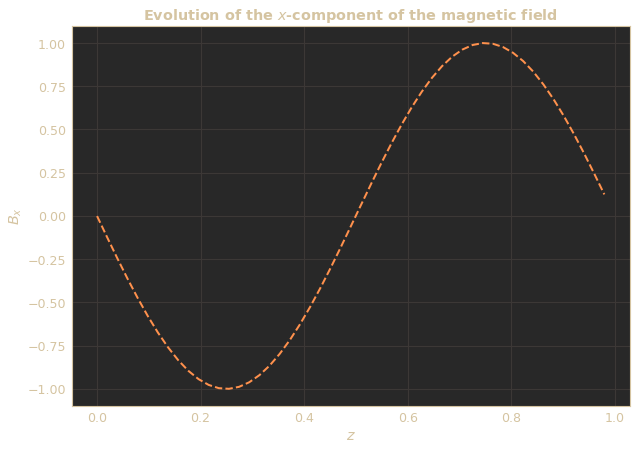

In [12]:
'''
    Create an animation
'''

from matplotlib import animation
from IPython.display import HTML
from celluloid import Camera 
%matplotlib inline

N_MAX   = 50
h       = (zf - z0) / N_MAX
z_grid  = np.linspace(z0, zf-h, N_MAX + 1)
dt      = h * COURANT
T_FINAL = 1.
U       = np.zeros((N_MAX+1,4))
t       = 0.

fig = plt.figure(figsize = (10, 7))

# Initiate camera
camera = Camera(fig)

while t <= T_FINAL:

    w = 2. * np.pi * (t - z_grid)
    U[:,0] = np.sin(w)     # B_x
    U[:,1] = np.cos(w)     # B_y
    U[:,2] = np.cos(w)     # E_x
    U[:,3] = -np.sin(w)    # E_y

    U = rk4_step(U, maxwell_rhs, dt, h, N = N_MAX)
    
    # capture trajectories
    plt.plot(z_grid, U[:,0], color='y', lw=2, linestyle='--')
    
    # output the labels+title just once, at the beginning
    if t == 0.:
        plt.xlabel(r'$z$', fontweight ='bold')
        plt.ylabel(r'$B_x$', fontweight ='bold')
        plt.title("Evolution of the $x$-component of the magnetic field", fontweight ='bold')
    
    # Capture frame
    camera.snap()
    
    t += dt
   
# Create and save animation
anim = camera.animate(interval = 40, repeat = True, repeat_delay = 500)
# anim.save('Figures/Bx_evo_video.mp4')

# Inline display
HTML(anim.to_html5_video())